In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt

# Iterations v/s Loss Storage
iters = [0]
loss_store = []

# Boundary Conditions 
left_temp = 1
right_temp = 0
x_l = 0
x_r = 0.7
t_i = 0
t_f = 1
s_i = 0.000000001
T_i = 0

# Parameters of the equation
c1 = 0.05
c2 = 0.8

# Setup training and test dataset
N_div_train = 35
N_bc = 200
N_ic = 200
a = 0.01
r = (x_r/a)**(1/(N_div_train-1))

x_train1 =[]
t_train1 =[]
for i in range(N_div_train):
    for j in range(N_div_train):
#         x_train1.append(x_l + (i-1)*(x_r-x_l)/N_div_train)
        x_train1.append(a*r**i)
        t_train1.append(t_i + (j-1)*t_f/N_div_train)

x_train1 = torch.FloatTensor(x_train1)
t_train1 = torch.FloatTensor(t_train1)   
x_bc = torch.ones(N_bc)*x_l
x_ic = torch.rand(N_ic)
t_bc = torch.rand(N_bc)
t_ic = torch.ones(N_ic)*t_i
x_train2 = torch.cat((x_train1,x_bc,x_ic),0)
t_train2 = torch.cat((t_train1,t_bc,t_ic),0)
null = torch.zeros(N_div_train*N_div_train + N_bc + N_ic)

x_train2 = x_train2.unsqueeze(-1)
t_train2 = t_train2.unsqueeze(-1)
x_train = x_train2.clone().detach().requires_grad_(True)
t_train = t_train2.clone().detach().requires_grad_(True)
null = null.unsqueeze(-1)

# Setup NN
n_input = 2
n_output = 1
n_nodes = 15
NN1 = nn.Sequential( nn.Linear(n_input, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_output) )

n_input = 1
NN2 = nn.Sequential( nn.Linear(1, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_output) )

for layer in NN1.modules():
    if isinstance(layer, nn.Linear):
         layer.weight.data.normal_(mean=0, std=0.2)
            
for layer in NN2.modules():
    if isinstance(layer, nn.Linear):
         layer.weight.data.normal_(mean=0, std=0.2)

# Hyper-parameters
learning_rate = 2e-4
learning_rate_1 = 9e-5
learning_rate_2 = 7e-5
n_iters = 62000
n_iters1 = 31000
n_iters2 = 31000
            
#loss function weights

w1 = 1
w2 = 1
w3 = 6
w4 = 1
w5 = 1
w6 = 12

# Setup Loss function and Optimiser
mse = nn.MSELoss()
# optimiser = torch.optim.SGD([*NN1.parameters(), *NN2.parameters()], lr=learning_rate)
optimiser = torch.optim.Adam([*NN1.parameters(), *NN2.parameters()], lr=learning_rate)
optimiser1 = torch.optim.Adam([*NN1.parameters(), *NN2.parameters()], lr=learning_rate_1)
optimiser2 = torch.optim.Adam([*NN1.parameters(), *NN2.parameters()], lr=learning_rate_2)


# For training NN
for i in range(n_iters):
    
    T = NN1( torch.cat((x_train, t_train),1) )
    dTdt = torch.autograd.grad(T, t_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    dTdx = torch.autograd.grad(T, x_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    dT2dx2 = torch.autograd.grad(dTdx, x_train, grad_outputs=torch.ones_like(dTdx), create_graph=True)[0]
    s = NN2(t_train)
    Ts = NN1( torch.cat((s, t_train),1) )
    dTsdx = torch.autograd.grad(Ts, s, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    dsdt = torch.autograd.grad(s, t_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    
    optimiser.zero_grad()
    eq1 = w1*mse( dTdt-c1*dT2dx2, null ) 
    ic1 = w2*mse( torch.mul(torch.where(t_train == t_i,1,0),(T - T_i)), null ) 
    bc1 = w3*mse( torch.mul(torch.where(x_train == x_l,1,0),(T - left_temp)), null ) 
    bc2 = w4*mse( Ts - right_temp, null ) 
    eq2 = w5*mse( dsdt+c2*dTsdx, null ) 
    ic2 = w6*mse( torch.mul(torch.where(t_train == t_i,1,0),(s - s_i)), null ) 
    loss = eq1 + bc1 + bc2 + ic1 + eq2 + ic2
    loss.backward()   
    optimiser.step()
    
    iters.append(iters[-1]+1)
    loss_store.append(loss.detach().numpy())
    
    if i%100 == 0:
        print('epoch = ',i,', loss = ',loss.detach().numpy())
        
    if i%1000 == 0:
        print('eq1_loss = ',eq1.detach().numpy())
        print('ic1_loss = ',ic1.detach().numpy())
        print('bc1_loss = ',bc1.detach().numpy())
        print('bc2_loss = ',bc2.detach().numpy())
        print('eq2_loss = ',eq2.detach().numpy())
        print('ic2_loss = ',ic2.detach().numpy())
        
    if(torch.where(loss < 0.015,1,0)):
        print('break')
        break

        
for i in range(n_iters1):
    
    T = NN1( torch.cat((x_train, t_train),1) )
    dTdt = torch.autograd.grad(T, t_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    dTdx = torch.autograd.grad(T, x_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    dT2dx2 = torch.autograd.grad(dTdx, x_train, grad_outputs=torch.ones_like(dTdx), create_graph=True)[0]
    s = NN2(t_train)
    Ts = NN1( torch.cat((s, t_train),1) )
    dTsdx = torch.autograd.grad(Ts, s, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    dsdt = torch.autograd.grad(s, t_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    
    optimiser1.zero_grad()
    eq1 = w1*mse( dTdt-c1*dT2dx2, null ) 
    ic1 = w2*mse( torch.mul(torch.where(t_train == t_i,1,0),(T - T_i)), null ) 
    bc1 = w3*mse( torch.mul(torch.where(x_train == x_l,1,0),(T - left_temp)), null ) 
    bc2 = w4*mse( Ts - right_temp, null ) 
    eq2 = w5*mse( dsdt+c2*dTsdx, null ) 
    ic2 = w6*mse( torch.mul(torch.where(t_train == t_i,1,0),(s - s_i)), null ) 
    loss = eq1 + bc1 + bc2 + ic1 + eq2 + ic2
    loss.backward()   
    optimiser1.step()
    
    iters.append(iters[-1]+1)
    loss_store.append(loss.detach().numpy())
    
    if i%100 == 0:
        print('epoch = ',i,', loss = ',loss.detach().numpy())
        
    if i%1000 == 0:
        print('eq1_loss = ',eq1.detach().numpy())
        print('ic1_loss = ',ic1.detach().numpy())
        print('bc1_loss = ',bc1.detach().numpy())
        print('bc2_loss = ',bc2.detach().numpy())
        print('eq2_loss = ',eq2.detach().numpy())
        print('ic2_loss = ',ic2.detach().numpy())
        
    if(torch.where(loss < 0.0035,1,0)):
        print('break')
        break
        
        
for i in range(n_iters2):
    
    T = NN1( torch.cat((x_train, t_train),1) )
    dTdt = torch.autograd.grad(T, t_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    dTdx = torch.autograd.grad(T, x_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    dT2dx2 = torch.autograd.grad(dTdx, x_train, grad_outputs=torch.ones_like(dTdx), create_graph=True)[0]
    s = NN2(t_train)
    Ts = NN1( torch.cat((s, t_train),1) )
    dTsdx = torch.autograd.grad(Ts, s, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    dsdt = torch.autograd.grad(s, t_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    
    optimiser2.zero_grad()
    eq1 = w1*mse( dTdt-c1*dT2dx2, null ) 
    ic1 = w2*mse( torch.mul(torch.where(t_train == t_i,1,0),(T - T_i)), null ) 
    bc1 = w3*mse( torch.mul(torch.where(x_train == x_l,1,0),(T - left_temp)), null ) 
    bc2 = w4*mse( Ts - right_temp, null ) 
    eq2 = w5*mse( dsdt+c2*dTsdx, null ) 
    ic2 = w6*mse( torch.mul(torch.where(t_train == t_i,1,0),(s - s_i)), null ) 
    loss = eq1 + bc1 + bc2 + ic1 + eq2 + ic2
    loss.backward()   
    optimiser2.step()
    
    iters.append(iters[-1]+1)
    loss_store.append(loss.detach().numpy())
    
    if i%100 == 0:
        print('epoch = ',i,', loss = ',loss.detach().numpy())
        
    if i%1000 == 0:
        print('eq1_loss = ',eq1.detach().numpy())
        print('ic1_loss = ',ic1.detach().numpy())
        print('bc1_loss = ',bc1.detach().numpy())
        print('bc2_loss = ',bc2.detach().numpy())
        print('eq2_loss = ',eq2.detach().numpy())
        print('ic2_loss = ',ic2.detach().numpy())


# Extract Weights and Biases
w1 = list(NN1.parameters())
w2 = list(NN2.parameters())

epoch =  0 , loss =  0.985754
eq1_loss =  0.02016863
ic1_loss =  0.000118608594
bc1_loss =  0.92489946
bc2_loss =  0.013271061
eq2_loss =  0.0011957732
ic2_loss =  0.026100542
epoch =  100 , loss =  0.46867207
epoch =  200 , loss =  0.44171438
epoch =  300 , loss =  0.43558696
epoch =  400 , loss =  0.4134706
epoch =  500 , loss =  0.26826972
epoch =  600 , loss =  0.22174414
epoch =  700 , loss =  0.21153696
epoch =  800 , loss =  0.19778821
epoch =  900 , loss =  0.18030612
epoch =  1000 , loss =  0.15947938
eq1_loss =  0.007951259
ic1_loss =  0.01807436
bc1_loss =  0.034302387
bc2_loss =  0.07058262
eq2_loss =  0.0009325766
ic2_loss =  0.027636169
epoch =  1100 , loss =  0.13812533
epoch =  1200 , loss =  0.11769763
epoch =  1300 , loss =  0.09909843
epoch =  1400 , loss =  0.08720654
epoch =  1500 , loss =  0.08177161
epoch =  1600 , loss =  0.07858879
epoch =  1700 , loss =  0.07597279
epoch =  1800 , loss =  0.073526196
epoch =  1900 , loss =  0.07112034
epoch =  2000 , loss =  0

epoch =  8800 , loss =  0.0077119675
epoch =  8900 , loss =  0.0071640164
epoch =  9000 , loss =  0.0071434705
eq1_loss =  0.0004790358
ic1_loss =  0.00037585793
bc1_loss =  0.0033552162
bc2_loss =  0.00019163878
eq2_loss =  6.85405e-05
ic2_loss =  0.0026731805
epoch =  9100 , loss =  0.0075477585
epoch =  9200 , loss =  0.0071030436
epoch =  9300 , loss =  0.007168963
epoch =  9400 , loss =  0.007063792
epoch =  9500 , loss =  0.0070780423
epoch =  9600 , loss =  0.0070269457
epoch =  9700 , loss =  0.007332734
epoch =  9800 , loss =  0.006991311
epoch =  9900 , loss =  0.0069950134
epoch =  10000 , loss =  0.0069564357
eq1_loss =  0.00045212053
ic1_loss =  0.0003762475
bc1_loss =  0.0032683606
bc2_loss =  0.00019599605
eq2_loss =  6.2128594e-05
ic2_loss =  0.0026015828
epoch =  10100 , loss =  0.006950119
epoch =  10200 , loss =  0.0069225845
epoch =  10300 , loss =  0.006909351
epoch =  10400 , loss =  0.0075986492
epoch =  10500 , loss =  0.0068741315
epoch =  10600 , loss =  0.006

epoch =  24200 , loss =  0.005673049
epoch =  24300 , loss =  0.00566743
epoch =  24400 , loss =  0.005659418
epoch =  24500 , loss =  0.0056540254
epoch =  24600 , loss =  0.005646395
epoch =  24700 , loss =  0.005639171
epoch =  24800 , loss =  0.005887436
epoch =  24900 , loss =  0.005624906
epoch =  25000 , loss =  0.0056235036
eq1_loss =  0.00036585476
ic1_loss =  0.00040059572
bc1_loss =  0.0024290634
bc2_loss =  0.00016629194
eq2_loss =  3.2487827e-05
ic2_loss =  0.00222921
epoch =  25100 , loss =  0.006338846
epoch =  25200 , loss =  0.005603942
epoch =  25300 , loss =  0.0056045577
epoch =  25400 , loss =  0.005590144
epoch =  25500 , loss =  0.0055840313
epoch =  25600 , loss =  0.0056947353
epoch =  25700 , loss =  0.005569254
epoch =  25800 , loss =  0.005565323
epoch =  25900 , loss =  0.0055672955
epoch =  26000 , loss =  0.005549482
eq1_loss =  0.00035993996
ic1_loss =  0.00039887114
bc1_loss =  0.002388212
bc2_loss =  0.00016064031
eq2_loss =  2.356279e-05
ic2_loss =  0

epoch =  9100 , loss =  0.0049355514
epoch =  9200 , loss =  0.004871663
epoch =  9300 , loss =  0.004930797
epoch =  9400 , loss =  0.004863348
epoch =  9500 , loss =  0.0048614526
epoch =  9600 , loss =  0.0048558577
epoch =  9700 , loss =  0.0048563587
epoch =  9800 , loss =  0.004849516
epoch =  9900 , loss =  0.004990778
epoch =  10000 , loss =  0.0048421947
eq1_loss =  0.0003190607
ic1_loss =  0.00038836032
bc1_loss =  0.001961968
bc2_loss =  0.000108411
eq2_loss =  3.2875385e-05
ic2_loss =  0.0020315193
epoch =  10100 , loss =  0.004875522
epoch =  10200 , loss =  0.0048350086
epoch =  10300 , loss =  0.0048358575
epoch =  10400 , loss =  0.0061419783
epoch =  10500 , loss =  0.0048247473
epoch =  10600 , loss =  0.004834782
epoch =  10700 , loss =  0.004817176
epoch =  10800 , loss =  0.004814552
epoch =  10900 , loss =  0.0062113306
epoch =  11000 , loss =  0.004807476
eq1_loss =  0.0003169731
ic1_loss =  0.00038857196
bc1_loss =  0.0019371372
bc2_loss =  0.00010664955
eq2_los

epoch =  24900 , loss =  0.0044443584
epoch =  25000 , loss =  0.0044392906
eq1_loss =  0.0002881184
ic1_loss =  0.000381243
bc1_loss =  0.0017173153
bc2_loss =  0.00010921726
eq2_loss =  4.868465e-05
ic2_loss =  0.0018947122
epoch =  25100 , loss =  0.004443558
epoch =  25200 , loss =  0.0044361893
epoch =  25300 , loss =  0.0045976723
epoch =  25400 , loss =  0.004432964
epoch =  25500 , loss =  0.0051964074
epoch =  25600 , loss =  0.0044281436
epoch =  25700 , loss =  0.004443358
epoch =  25800 , loss =  0.0044237673
epoch =  25900 , loss =  0.0044236844
epoch =  26000 , loss =  0.0044218358
eq1_loss =  0.00028488509
ic1_loss =  0.0003854745
bc1_loss =  0.0017036155
bc2_loss =  0.0001047318
eq2_loss =  5.0984574e-05
ic2_loss =  0.0018921446
epoch =  26100 , loss =  0.0044192513
epoch =  26200 , loss =  0.006701993
epoch =  26300 , loss =  0.004415268
epoch =  26400 , loss =  0.0045726895
epoch =  26500 , loss =  0.004411597
epoch =  26600 , loss =  0.006078394
epoch =  26700 , loss

In [1]:
# Plot Loss v/s iteration
plt.figure(0)
plt.plot(iters[1:len(iters)], loss_store[0:len(iters)])
plt.ylabel('Loss')
plt.xlabel('Iterations')

NameError: name 'plt' is not defined

In [31]:
# lam Calculation
x = []
er = []
cnt = 0
for i in np.arange(0.1, 5, 0.001):
    x.append(i)
    er.append(math.erf(x[-1]))
    cnt = cnt+1
    
x = np.array(x)
er = np.array(er)
y =[]
y = np.exp(-x*x)/(er*math.sqrt(math.pi))-x*c1/c2

for i in range(1,cnt):
    if(y[i]*y[i-1]<0):
        lam = x[i]
        print(lam)

1.3880000000000012


Text(0.5, 0, 'Domain')

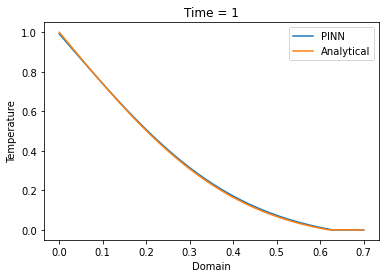

In [53]:
# Temperature Distribution

N_test = 2000

t_pred = 1
x_test = torch.linspace(x_r,x_l,N_test)
t_test = torch.ones(N_test)*t_pred
x_test = x_test.unsqueeze(-1)
t_test = t_test.unsqueeze(-1)

y_pred = NN1( torch.cat((x_test, t_test),1) )
s_pred = NN2(t_test)

y_pred = y_pred.detach().numpy()
s_pred = s_pred.detach().numpy()
x_test = x_test.detach().numpy()
t_test = t_test.detach().numpy()

# PINN
for i in range(N_test):
    if(x_test[i]>s_pred[i]):
        y_pred[i] = 0 
plt.plot(x_test, y_pred)
        
# Analytical
s_an = np.sqrt(c1*t_pred)*2*lam
y_an = []
for i in range(N_test):
    if(x_test[i]>s_an):
        y_an.append(0)
    else:
        y_an.append(1 - math.erf( x_test[i]/( 2*np.sqrt(c1*t_test[i]) ) )/ math.erf(lam) )     
plt.plot(x_test, y_an)

plt.legend(['PINN', 'Analytical'])
plt.title('Time = '+ str(t_pred) )
plt.ylabel('Temperature')
plt.xlabel('Domain')

Text(0, 0.5, 'Interface Position')

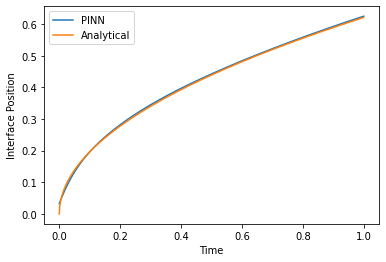

In [54]:
# Interface Position
t_test = torch.linspace(t_i, t_f, N_test)
t_test = t_test.unsqueeze(-1)
s_pred = NN2(t_test)
T_interface = NN1( torch.cat((s_pred, t_test),1) )

t_test = t_test.detach().numpy()
s_pred = s_pred.detach().numpy()
T_interface = T_interface.detach().numpy()

plt.plot(t_test,s_pred)
plt.plot(t_test, np.sqrt(c1*t_test)*2*lam)
plt.legend(['PINN', 'Analytical'])
plt.xlabel('Time')
plt.ylabel('Interface Position')